In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import seaborn as sns
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.utils import to_categorical

input_folder = "/content/drive/MyDrive/3d_Data2/Data"

# Initialize lists to store the image data and labels
features = []
labels = []

# Load a pre-trained VGG16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

# Flatten the output of the base model
output_shape = np.prod(base_model.output_shape[1:])

flattened_features = []

# Iterate over the image files in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith(".png"):
        image_path = os.path.join(input_folder, filename)
        image = Image.open(image_path)

        image = image.resize((224, 224))

        image_array = np.array(image)

        image_array = preprocess_input(image_array) 

        feature = base_model.predict(np.expand_dims(image_array, axis=0))

        label= filename.split("_")[1] + "_" + filename.split("_")[2]

        flattened_features.append(feature.flatten())

        labels.append(label)



Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 23ms/step


In [ ]:
from keras.utils import to_categorical

flattened_features = np.array(flattened_features)

# Encode the class labels into numeric values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

unique_labels = np.unique(labels)
print(f"Number of unique labels: {len(unique_labels)}")

# Perform one-hot encoding
one_hot_encoded_labels = to_categorical(encoded_labels)

# Print the shape of the one-hot encoded labels
print(f"Shape of one-hot encoded labels: {one_hot_encoded_labels.shape}")

print(flattened_features.shape)
# Split the dataset into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(flattened_features, encoded_labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Number of unique labels: 6
Shape of one-hot encoded labels: (16725, 6)
(16725, 25088)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the number of classes for the CNN model
num_classes = len(np.unique(encoded_labels))

# Create the CNN model
model = Sequential([
    Dense(128, activation="relu", input_shape=(output_shape,)),  
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Convert the feature data to numpy arrays
X_train = np.array(X_train).reshape(-1, output_shape)
X_val = np.array(X_val).reshape(-1, output_shape)
X_test = np.array(X_test).reshape(-1, output_shape)

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=15, validation_data=(X_val, y_val))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Predict labels for the test set
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Calculate the confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred)



Epoch 1/15
335/335 [==============================] - 7s 9ms/step - loss: 2.5353 - accuracy: 0.5972 - val_loss: 0.3920 - val_accuracy: 0.8554
Epoch 2/15
335/335 [==============================] - 2s 6ms/step - loss: 0.7797 - accuracy: 0.7293 - val_loss: 0.3840 - val_accuracy: 0.8890
Epoch 3/15
335/335 [==============================] - 2s 6ms/step - loss: 0.7021 - accuracy: 0.7533 - val_loss: 0.3414 - val_accuracy: 0.9212
Epoch 4/15
335/335 [==============================] - 3s 9ms/step - loss: 0.6625 - accuracy: 0.7669 - val_loss: 0.3033 - val_accuracy: 0.9182
Epoch 5/15
335/335 [==============================] - 2s 6ms/step - loss: 0.6552 - accuracy: 0.7793 - val_loss: 0.2951 - val_accuracy: 0.9178
Epoch 6/15
335/335 [==============================] - 2s 6ms/step - loss: 0.5897 - accuracy: 0.8000 - val_loss: 0.2862 - val_accuracy: 0.9324
Epoch 7/15
335/335 [==============================] - 2s 6ms/step - loss: 0.5985 - accuracy: 0.8016 - val_loss: 0.2570 - val_accuracy: 0.9309
Epoch 

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image

# Path to a test image
test_image_path = '/content/edited.jpg'

# Load the image and resize it
test_image = Image.open(test_image_path)
test_image = test_image.resize((224, 224))

# Convert the image to a numpy array and preprocess it
test_image_array = np.array(test_image)

# Ensure the test image is preprocessed correctly
test_image_array = preprocess_input(test_image_array)

# Use VGG16 to extract features
feature = base_model.predict(np.expand_dims(test_image_array, axis=0))

# Flatten the extracted features to match the model's expected input shape
flattened_feature = feature.reshape(-1)

# Ensure the flattened feature has the correct size (25088)
assert flattened_feature.shape[0] == 25088, "The flattened feature does not match the expected size."

# Predict the class with the model
predictions = model.predict(np.expand_dims(flattened_feature, axis=0))


# Decode the predicted class
predicted_class_index = np.argmax(predictions)
predicted_class = label_encoder.inverse_transform([predicted_class_index])[0]

print(f"Predicted class: {predicted_class}")


1/1 [==============================] - 0s 132ms/step
Predicted class: Hexagoncap_front


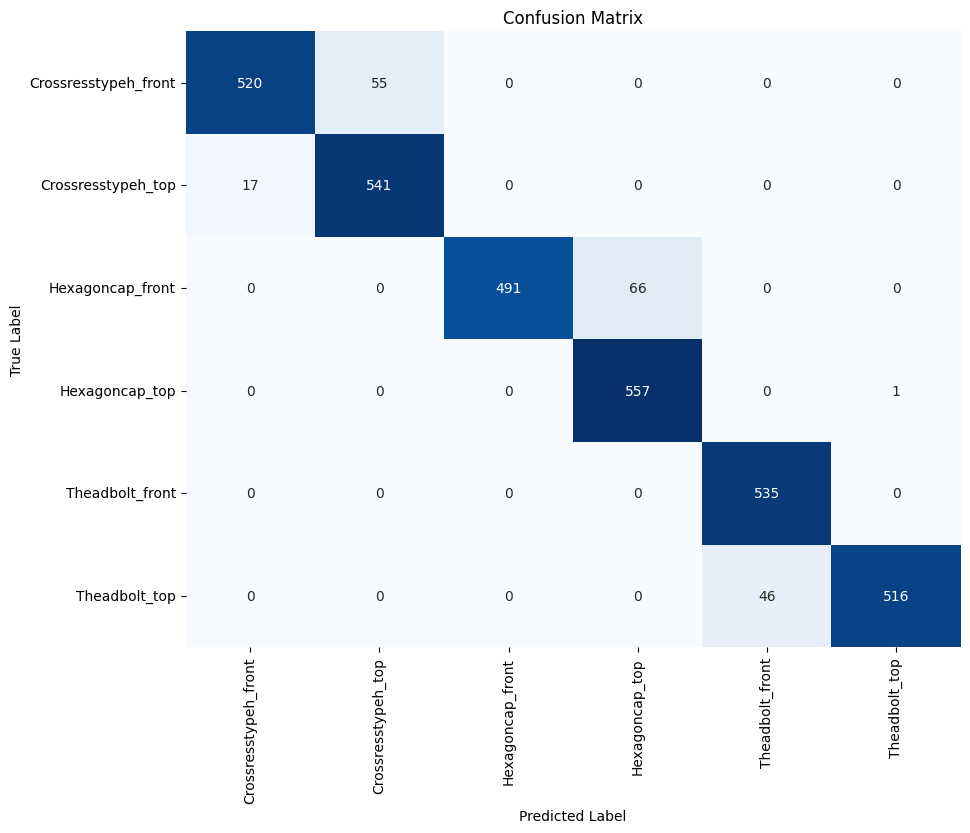

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

class_names = label_encoder.classes_

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


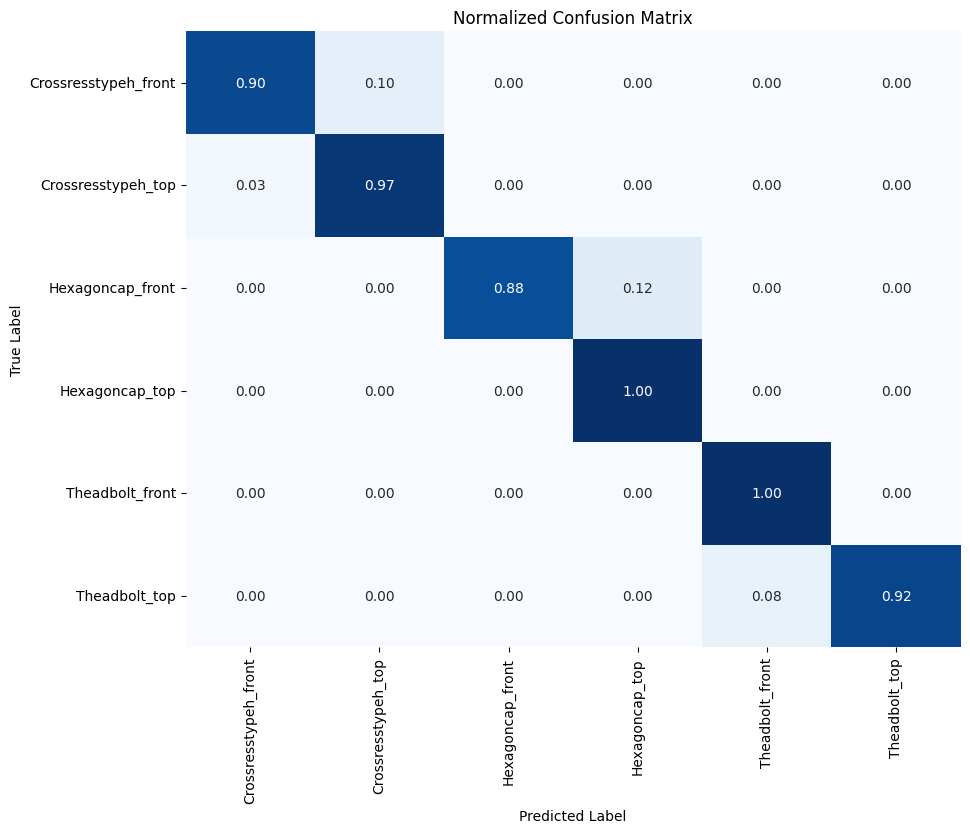

In [ ]:
# Normalize the confusion matrix
confusion_mtx_normalized = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx_normalized, annot=True, fmt=".2f", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()


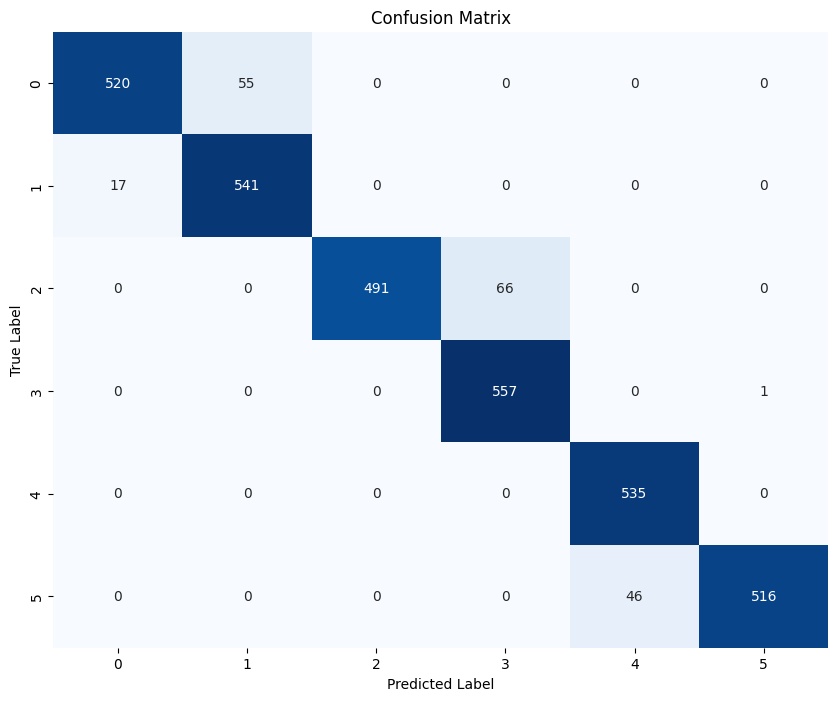

In [ ]:
import matplotlib.pyplot as plt

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


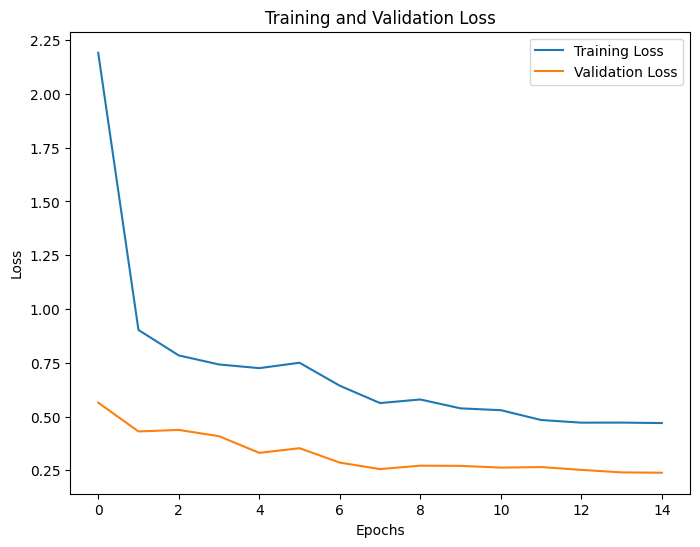

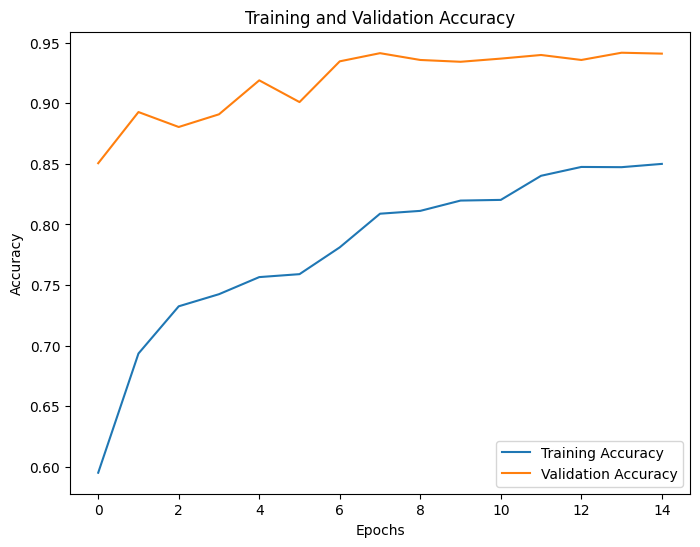

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
import numpy as np
from tensorflow import keras

# Save the model
model.save("/content/model.h5")

# Save the label encoder
np.save("/content/label_encoder.npy", label_encoder.classes_)
# Load the model
model = keras.models.load_model('/content/model.h5')

# Load the label encoder
label_encoder = LabelEncoder()
label_encoder.classes_ = np.load('/content/label_encoder.npy')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
Total params: 3220038 (12.28 MB)
Trainable params: 3220038 (12.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
!pip install tf-keras-vis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 1.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from sklearn.metrics.pairwise import cosine_similarity
from tf_keras_vis.utils import normalize
from tf_keras_vis.gradcam import GradcamPlusPlus

directory = '/content/drive/MyDrive/3d_Data2/Data'
image_paths = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(('.jpg', '.png'))]


# Load a pre-trained VGG16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.output)

# Function to preprocess the image and extract features
def preprocess_and_extract_features(image_path):
    image = Image.open(image_path)
    image = image.resize((224, 224))
    image_array = np.array(image)
    image_array = preprocess_input(image_array)
    feature = model.predict(np.expand_dims(image_array, axis=0))[0]
    return feature.flatten()

# Function to find similar images
def find_similar_images(given_image_feature, all_features, threshold=0.8):
    similar_images = []
    given_image_feature = given_image_feature.reshape(1, -1)

    for i, feature in enumerate(all_features):
        feature = feature.reshape(1, -1)
        similarity = cosine_similarity(given_image_feature, feature)[0][0]
        if similarity >= threshold:
            similar_images.append(i)
    return similar_images

# Function to generate CAM
def generate_cam(image_array, model, penultimate_layer=-1):
    gradcam = GradcamPlusPlus(model, model_modifier=None, clone=False)
    cam = gradcam(np.array([image_array]), penultimate_layer=penultimate_layer)
    heatmap = normalize(cam)
    plt.imshow(heatmap[0], cmap='jet', alpha=0.5)
    plt.show()

# Assuming you have a list of image paths in 'image_paths'
all_features = [preprocess_and_extract_features(image_path) for image_path in image_paths]




Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 34ms/step


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model, Model
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize
from PIL import Image
from tensorflow.keras.applications.vgg16 import preprocess_input
# Step 1: Save Your Trained Model
model.save('my_model.h5')
# Step 4: Load the Saved Model
model = load_model('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


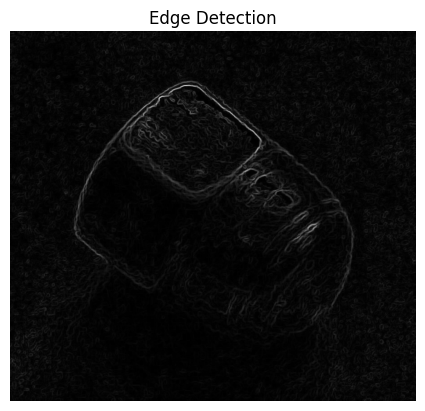

In [ ]:
from skimage import filters, io, color
import matplotlib.pyplot as plt

# Edge detection function
def plot_edge_detection(image):
    edges = filters.sobel(color.rgb2gray(image))
    plt.imshow(edges, cmap='gray')
    plt.title('Edge Detection')
    plt.axis('off')
    plt.show()

# Load an image
image = io.imread('path/to/your/image.jpg')  # Replace with your image path

# Call the function
plot_edge_detection(image)



In [ ]:
from skimage.transform import resize

# Resize the predicted images to match the dimensions of the original test images
X_test_pred = model.predict(X_test)
X_test_pred_resized = []
for i in range(len(X_test_pred)):
    resized_pred = resize(X_test_pred[i], X_test[i].shape)
    X_test_pred_resized.append(resized_pred)

# Calculate SSIM scores
ssim_scores = []
for i in range(len(X_test)):
    score = ssim(X_test[i], X_test_pred_resized[i], multichannel=True)
    ssim_scores.append(score)
average_ssim = np.mean(ssim_scores)

print("Average SSIM score:", average_ssim)

17/17 [==============================] - 27s 2s/step


<ipython-input-14-b535a620df11>:13: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  score = ssim(X_test[i], X_test_pred_resized[i], multichannel=True)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


Average SSIM score: 0.5954284393274989


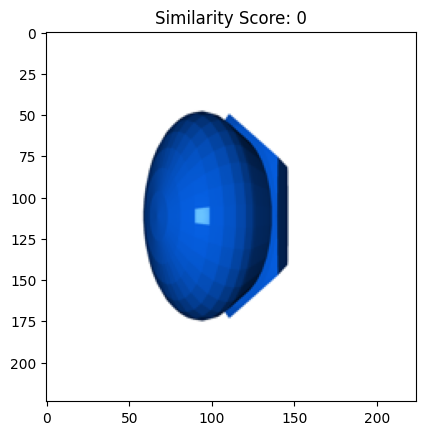

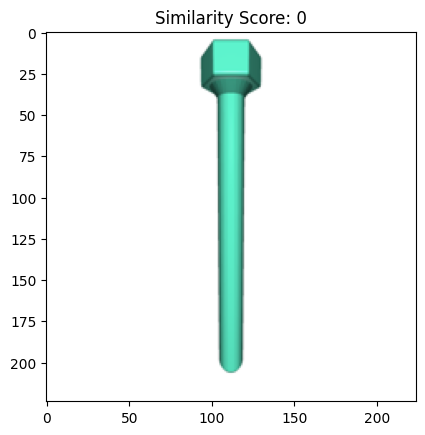

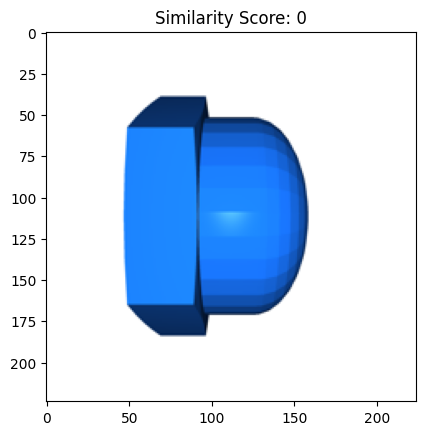

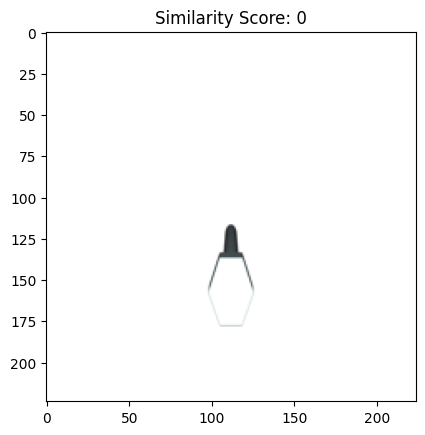

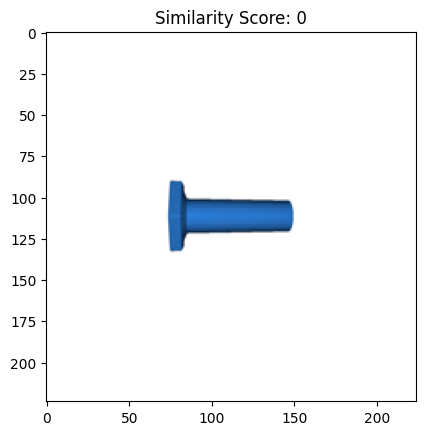

In [ ]:
import matplotlib.pyplot as plt
similarity_scores = []
for i, embedding in enumerate(training_set_embeddings):
    try:
        score = ssim(embedding.squeeze(), input_embedding.squeeze(), channel_axis=0)
        similarity_scores.append((score, i))
    except ZeroDivisionError:
        similarity_scores.append((0, i))

# Sort the similarity scores
similarity_scores.sort(reverse=True)

# Considering the top N similar images (you can adjust N as needed)
N = 5
top_similar_images = similarity_scores[:N]

# Retrieve top similar images from training set based on index
for score, index in top_similar_images:
    similar_image = X_train[index]
    plt.imshow(similar_image)
    plt.title(f"Similarity Score: {score}")
    plt.show()

This below part for auto tuner for hyper parameters only for testing purpose. Below is not the original layer.Change the model layer accordingly

In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 2.6 MB/s eta 0:00:00


In [ ]:
from kerastuner import RandomSearch

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
                            kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
                            activation='relu',
                            input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
                            kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
                            activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
                           activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


<ipython-input-7-13f40636a9e3>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


In [ ]:
tuner_search = RandomSearch(build_model,
                            objective='val_accuracy',
                            max_trials=25,
                            directory='output',
                            project_name="3d_image_classification")

tuner_search.search(datagen.flow(X_train, y_train, batch_size=32), epochs=3, validation_data=(X_val, y_val))


Trial 25 Complete [00h 00m 18s]
val_accuracy: 0.3888888955116272

Best val_accuracy So Far: 0.6944444179534912
Total elapsed time: 00h 03m 53s


In [ ]:
best_hps=tuner_search.get_best_hyperparameters(num_trials=1)[0]

model = tuner_search.hypermodel.build(best_hps)

model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=10, validation_data=(X_val, y_val))


Epoch 1/10
5/5 [==============================] - 3s 276ms/step - loss: 2.5682 - accuracy: 0.3333 - val_loss: 1.1337 - val_accuracy: 0.2778
Epoch 2/10
5/5 [==============================] - 3s 568ms/step - loss: 1.1222 - accuracy: 0.4113 - val_loss: 1.0944 - val_accuracy: 0.5000
Epoch 3/10
5/5 [==============================] - 2s 376ms/step - loss: 1.0941 - accuracy: 0.4894 - val_loss: 1.0725 - val_accuracy: 0.5833
Epoch 4/10
5/5 [==============================] - 1s 332ms/step - loss: 1.0573 - accuracy: 0.4326 - val_loss: 1.0524 - val_accuracy: 0.6111
Epoch 5/10
5/5 [==============================] - 2s 288ms/step - loss: 1.0717 - accuracy: 0.5603 - val_loss: 1.0504 - val_accuracy: 0.7222
Epoch 6/10
5/5 [==============================] - 2s 294ms/step - loss: 1.0239 - accuracy: 0.5957 - val_loss: 0.9921 - val_accuracy: 0.6667
Epoch 7/10
5/5 [==============================] - 2s 291ms/step - loss: 1.0209 - accuracy: 0.5745 - val_loss: 0.9025 - val_accuracy: 0.6944
Epoch 8/10
5/5 [====